### Nama : AARON WINSTON GHO
### NIM : 2702210522

# 1A Datasets About Consuming Energy By Using Solar Panel

Information About The Datasets:
It's a datasets that consists of 12 columns that is month, hour, day of week, holiday, temperature, humidity, Square footage, Occupancy, HVACUsage, LightingUsage, RenewableEnergy, and Energy Consumption. From this datasets we will try to build a sequential and functional model with Energy consumption as the Y or output and all other columns as input.

Main Goals Of the Datasets:
Predict the amount of energy consumed by a building with solar panel.

Column Information:
- **Month**: The month of the year when the data was recorded.
- **Hour**: The hour of the day when the data was recorded.
- **DayOfWeek**: The day of the week when the data was recorded.
- **Holiday**: Indicates whether the day was a holiday (Yes/No).
- **Temperature**: The average daily temperature in Celsius
- **Humidity**: The average daily humidity level (%).
- **SquareFootage**: The area of the building being monitored in square meters.
- **Occupancy**: The total number of people occupying the building.
- **HVACUsage**: Indicates whether the HVAC system was in use (On/Off).
- **LightingUsage**: Indicates whether the lighting system was in use (On/Off).
- **RenewableEnergy**: The amount of renewable energy generated at the time of data collection.
- **EnergyConsumption**: The amount of energy consumed at the time of data collection.

# Importing Library

In [197]:
!pip install keras-tuner

In [198]:
import keras_tuner as kt

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as gro
from plotly.subplots import make_subplots
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import random
from scipy import stats
from scipy.stats import shapiro

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error
from sklearn.preprocessing import RobustScaler,StandardScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder,MinMaxScaler

SEED_VALUE=123
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

### Checking the device ( GPU needed so we can do faster running for the models later )

In [199]:
print('num Device: ',len(tf.config.experimental.list_physical_devices()))
print(tf.config.experimental.list_physical_devices())

num Device:  2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Reading the datasets, because it was provided with .parquet so we'll gonna read_parquet instead of csv

Here we will change the given dataset into csv from parquet because one of the advantages and disadvantages of the parquet data type is that there is a library that can convert nan directly to 0. Now this can be dangerous if the missing value is categorical or we don't want to replace it but drop it away because it is below 5%.

In [200]:
df = pd.read_parquet('dataset_1A.parquet')
df.to_csv('dataset_1A.csv', index=False)

In [201]:
df = pd.read_csv('dataset_1A.csv')
df

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.057358
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.889177
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.202098
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.439179
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.902272
...,...,...,...,...,...,...,...,...,...,...,...,...
1227,9,2,Saturday,No,29.412360,47.368427,1905.249762,3,On,Off,9.602456,79.749119
1228,6,16,Saturday,Yes,24.019593,59.272447,1274.096723,9,Off,On,21.973733,72.937710
1229,1,1,Tuesday,No,21.926454,44.605974,1135.054165,5,On,On,4.858261,77.024122
1230,3,2,Monday,No,24.581719,32.637069,1295.556323,5,Off,Off,1.763935,71.751361


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 115.6+ KB


In [203]:
df.isna().sum()

,0
Month,0
Hour,0
DayOfWeek,0
Holiday,0
Temperature,0
Humidity,0
SquareFootage,0
Occupancy,0
HVACUsage,0
LightingUsage,0


here we can see that there is a missing value on the y value so we're just gonna drop it because it was lower than 5% of the data

In [204]:
df = df.dropna()
df.isna().sum()

,0
Month,0
Hour,0
DayOfWeek,0
Holiday,0
Temperature,0
Humidity,0
SquareFootage,0
Occupancy,0
HVACUsage,0
LightingUsage,0


In [205]:
int(df.duplicated().sum())

0

No dups no problemo so we're just gonna check the unique value of each categorical to identify if there's a typo on the data

In [206]:
categorical_columns = ['Month', 'DayOfWeek', 'Holiday', 'HVACUsage', 'LightingUsage']
print("Unique Values (Categorical/Binary Columns):")
for col in categorical_columns:
    print(f"{col}: {df[col].unique()}")

Unique Values (Categorical/Binary Columns):
Month: ['8' '1' '7' '10' '4' '2' '5' '6' '11' '9' '12' '3' 'Sep' 'July'
 'September']
DayOfWeek: ['Sunday' 'Wednesday' 'Saturday' 'Friday' 'Tuesday' 'Monday' 'Thursday']
Holiday: ['Yes' 'No']
HVACUsage: ['On' 'Off']
LightingUsage: ['Off' 'On']


Hoho Jebakan Batman, as expected there's gonna be typo in the data for the "Month Column" so we're gonna change for all September and Sep to 9 and July to 7 also converting the string numbers to real numbers

### Converting Typo

In [207]:
month_map_str = {
    'January': '1', 'Jan': '1', '1': '1',
    'February': '2', 'Feb': '2', '2': '2',
    'March': '3', 'Mar': '3', '3': '3',
    'April': '4', 'Apr': '4', '4': '4',
    'May': '5', '5': '5',
    'June': '6', 'Jun': '6', '6': '6',
    'July': '7', 'Jul': '7', '7': '7',
    'August': '8', 'Aug': '8', '8': '8',
    'September': '9', 'Sep': '9', '9': '9',
    'October': '10', 'Oct': '10', '10': '10',
    'November': '11', 'Nov': '11', '11': '11',
    'December': '12', 'Dec': '12', '12': '12'
}
df.loc[:, 'Month'] = df['Month'].astype(str).str.strip().map(month_map_str)

kinda overkill but just incase there's an unexpected twist on the data so we're gonna change it to string numbers. WHY? because we want to visualize it as categorical then later convert it into numbers

In [208]:
categorical_columns = ['Month', 'DayOfWeek', 'Holiday', 'HVACUsage', 'LightingUsage']
print("Unique Values (Categorical/Binary Columns):")
for col in categorical_columns:
    print(f"{col}: {df[col].unique()}")

Unique Values (Categorical/Binary Columns):
Month: ['8' '1' '7' '10' '4' '2' '5' '6' '11' '9' '12' '3']
DayOfWeek: ['Sunday' 'Wednesday' 'Saturday' 'Friday' 'Tuesday' 'Monday' 'Thursday']
Holiday: ['Yes' 'No']
HVACUsage: ['On' 'Off']
LightingUsage: ['Off' 'On']


In [209]:
num_cols = []
cat_cols = []

for i in df.columns:
    if df[i].dtype == 'object':
        cat_cols.append(i)
    elif "int" in str(df[i].dtype) or "float" in str(df[i].dtype):
        num_cols.append(i)

print(num_cols)
print(cat_cols)

['Hour', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']
['Month', 'DayOfWeek', 'Holiday', 'HVACUsage', 'LightingUsage']


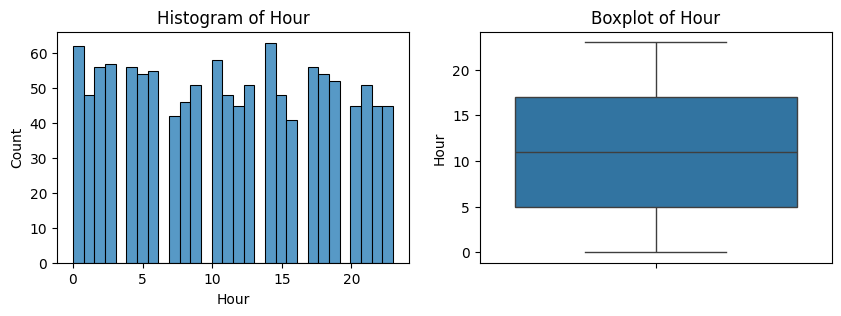

Skewness of Hour: 0.030769032790766912
Kurtosis of Hour: -1.2150572437969342


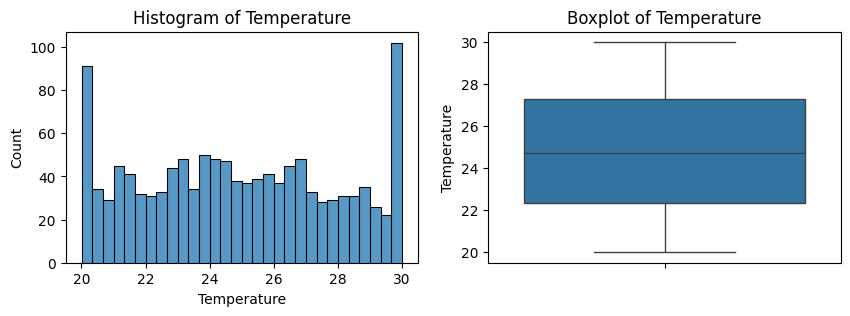

Skewness of Temperature: 0.07917899946764269
Kurtosis of Temperature: -1.1134041943207904


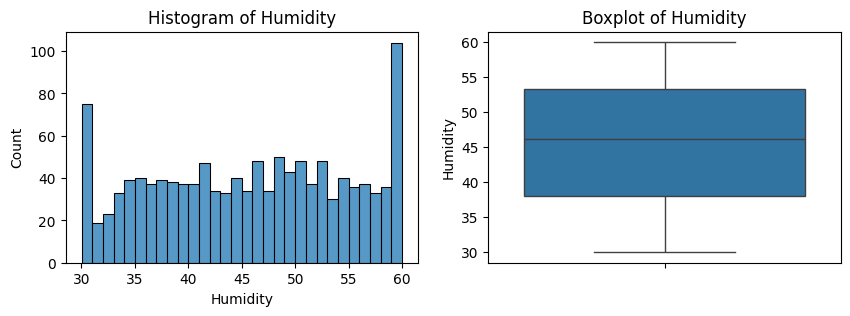

Skewness of Humidity: -0.07310295158672091
Kurtosis of Humidity: -1.1484387805563727


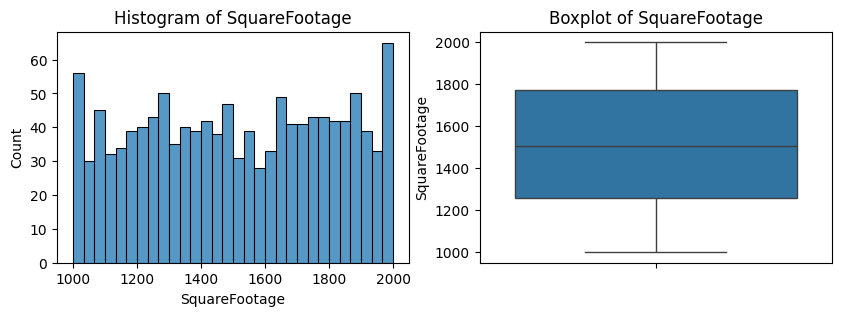

Skewness of SquareFootage: -0.03249590133536654
Kurtosis of SquareFootage: -1.2053779662975286


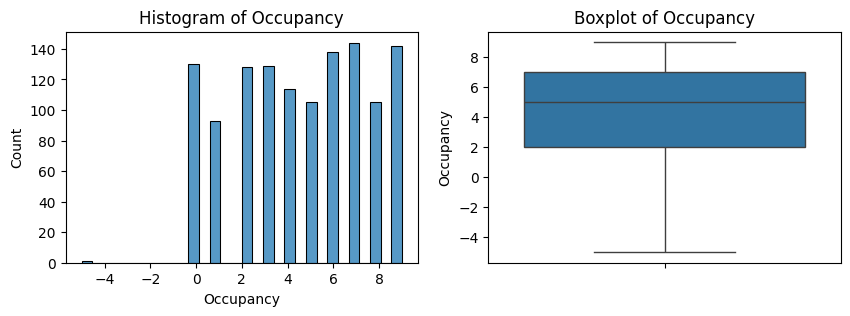

Skewness of Occupancy: -0.0798321246262843
Kurtosis of Occupancy: -1.149902998502459


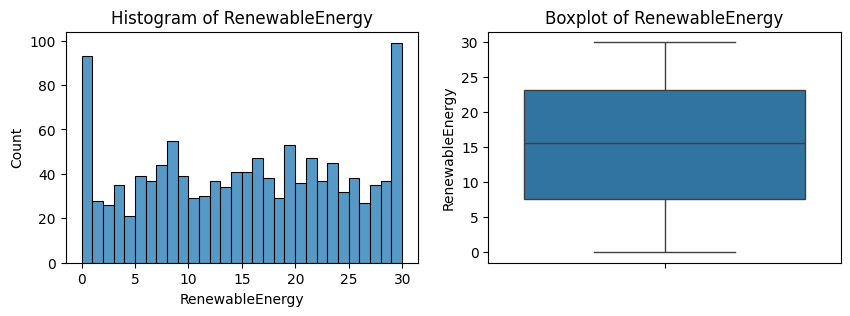

Skewness of RenewableEnergy: -0.04772601464301403
Kurtosis of RenewableEnergy: -1.1682739430073996


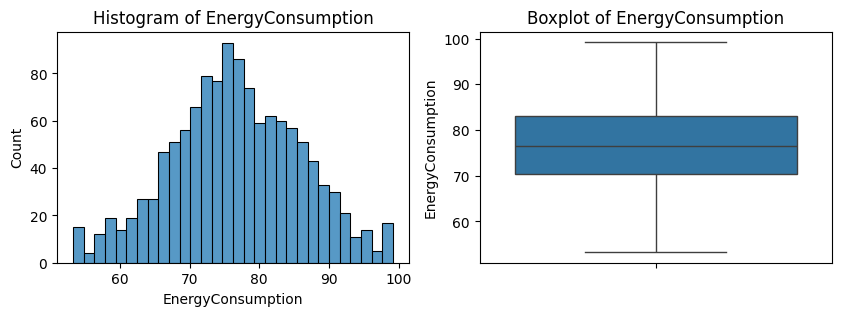

Skewness of EnergyConsumption: -0.03074931328807071
Kurtosis of EnergyConsumption: -0.23935154513990708


In [210]:
def check_distribution_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 3))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title(f'Histogram of {col}')

        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        print(f'Skewness of {col}:', df[col].skew())
        print(f'Kurtosis of {col}:', df[col].kurt())

check_distribution_outliers(df, num_cols)

from the visualization of the numerical column we can evaluate for each column starting with
1. Hour : we can see that the data is very simetris distributed, which we can see from the value of skewness that is close to 0. for the outliers gladly there arent any outliers in this column. Unique thing about this we can see that not every hour people are consuming energy in their life from the datasets. Anyways, for the -1 kurtosis indicates that the distribution is not peak or there arent outlier or extreme value on the distribution and also lower peaks or data.
2. Temperature : we can see that the data is actually distribute simetrically, the (-) indicating that the graph is kinda skew to right. this is proofen by the highest data is at "30C". Also we can see for the kurtosis -1 is the same with hour, it indicates lower peaks and no outliers and extreme values detected.
3. Humitidity : Humidity is one of column that significantly impacts energy consumption, with high humidity increasing cooling demands and low humidity raising heating needs. we can see that from the distribution is kinda look like temperature because they are actually associated together.
4.Square footage : from the distribution we can see that square footage is also simetrically distributed and is lower peak because of the kurtosis that is negative and below 2. This indicates no outliers and extreme value in the distribution and we can see it cleary in the boxplot.
5. Occupancy : occupancy is a column indicates how many person is in a building, here we can see something's wrong with it in the visualization. How could a occupancy be (-) value, so we're gonna remove that - value, for 0 it's still make sense some building without person that can consume energy by automatic things like CCTV is something that used energy consumption 24/7. for the distribution is normally distributed and no outliers detected. kurtosis - indicating is a flat data one.
6. Renewable energy : we can see that from the distribution is simetrically and it looks life the distribution of temperature and humitidity. The kurtosis negatve indicating that the data is flat. From the boxplot we can see there arent any outliers and Extreme values in the data.
7. Energy Consumption : Last but not least is the energy consumption, we can see that is very well distributed from left to right from the skewness score that is very close to 0 and no outliers from the boxplot. We can see that the data kurtosis also close 0 to make sure that the distribution is a normal.

### Fixing the (-) on the Occupancy

In [211]:
df = df[df['Occupancy'] >= 0]

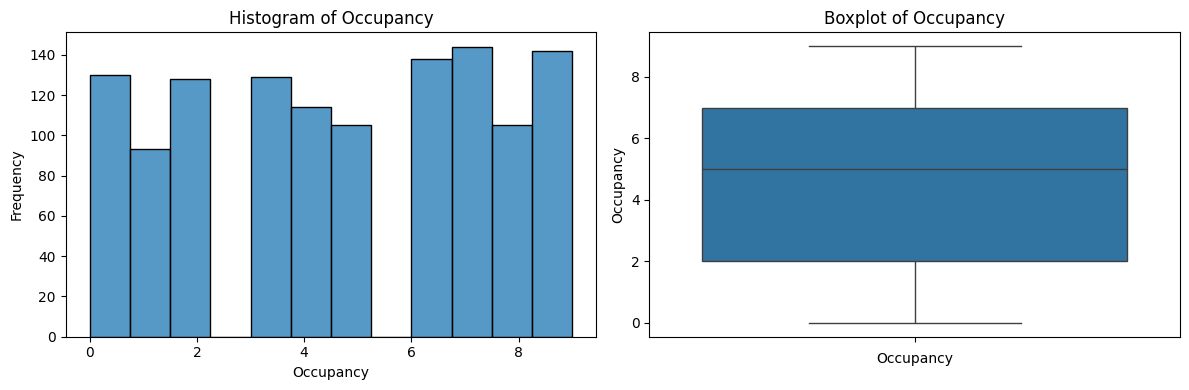

In [212]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Occupancy'])
plt.title('Boxplot of Occupancy')
plt.xlabel('Occupancy')

plt.subplot(1, 2, 1)
sns.histplot(df['Occupancy'])
plt.title('Histogram of Occupancy')
plt.xlabel('Occupancy')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Visualization for Categorical

In [213]:
from pandas.api.types import CategoricalDtype

# Define the correct order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_order = [
    '1', '2', '3', '4', '5', '6',
    '7', '8', '9', '10', '11', '12'
]

# Apply the ordering to your DataFrame
df['DayOfWeek'] = df['DayOfWeek'].astype(CategoricalDtype(categories=day_order, ordered=True))
df['Month'] = df['Month'].astype(CategoricalDtype(categories=month_order, ordered=True))

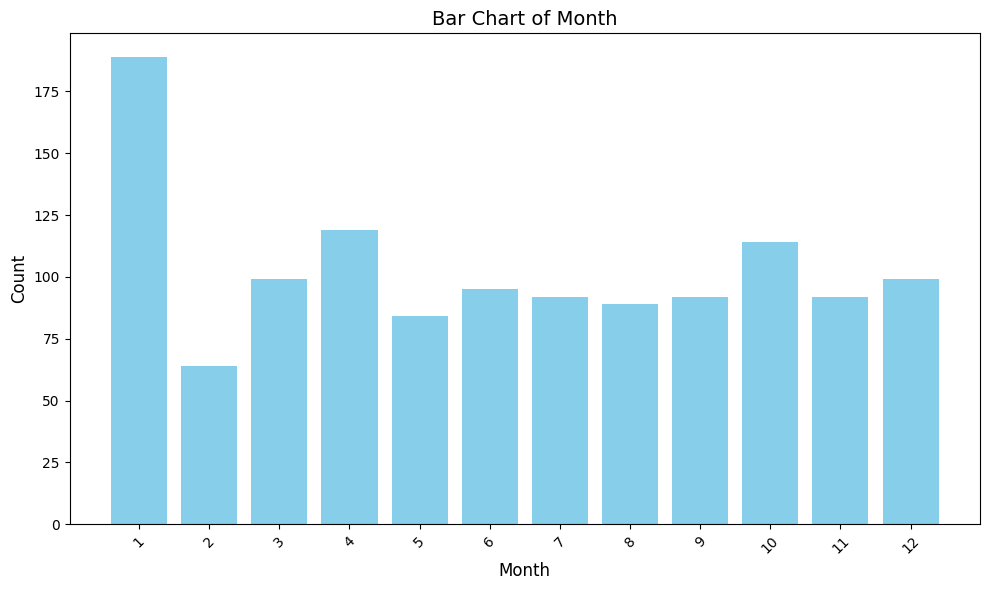

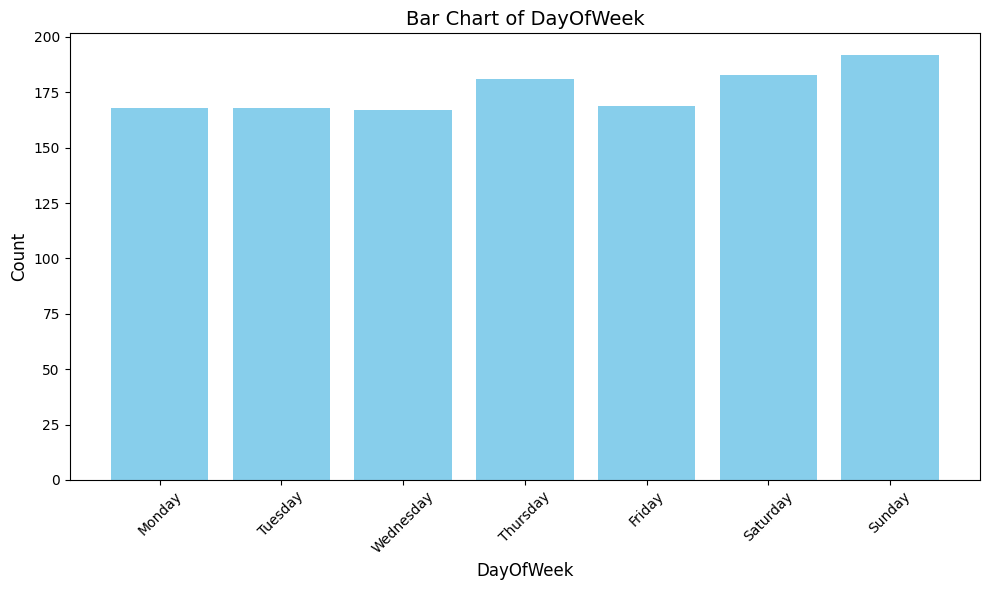

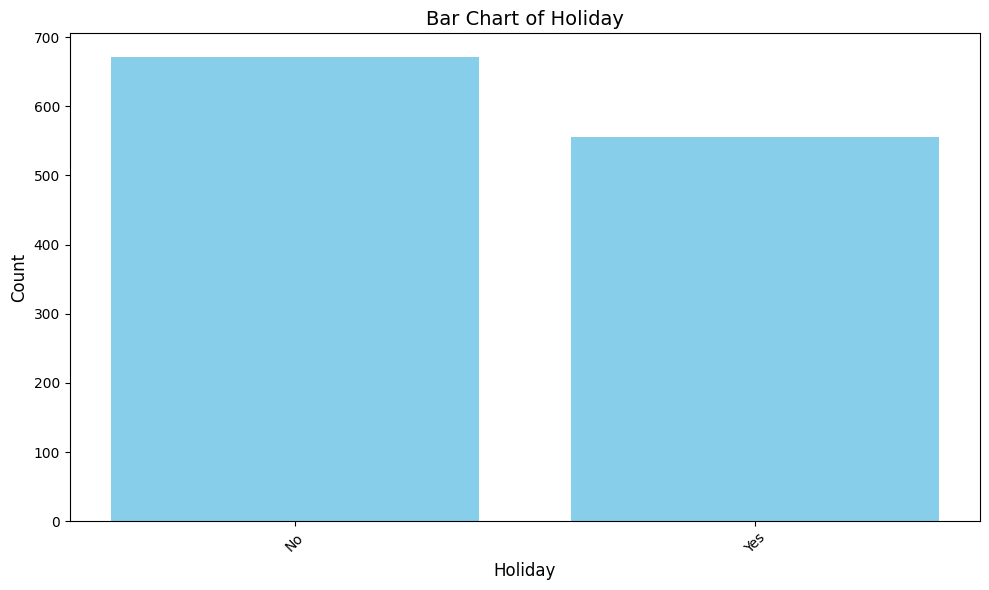

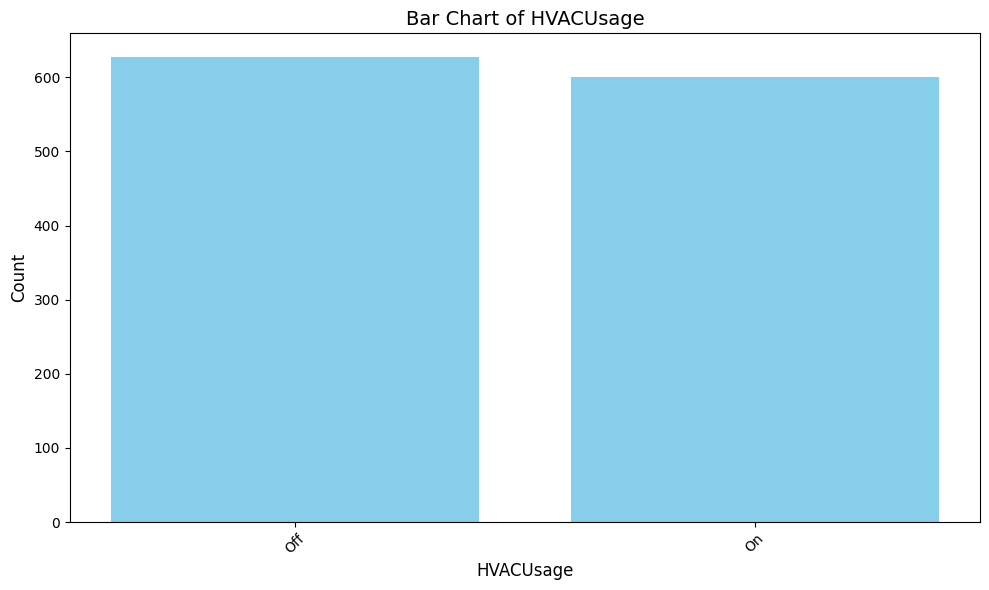

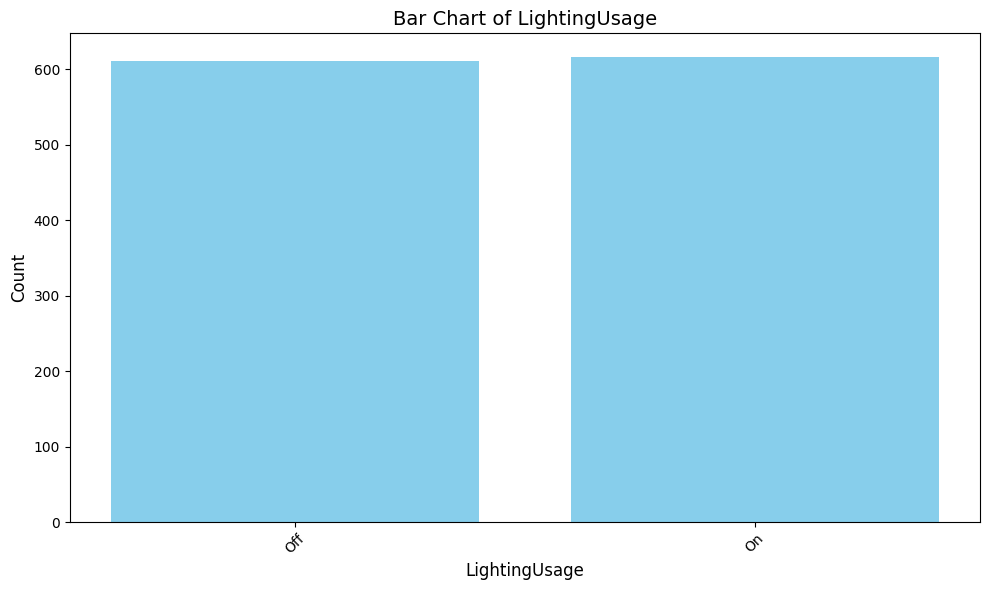

In [214]:
def plot_categorical(data, columns):
    for column in columns:
        value_counts = data[column].value_counts().sort_index().reset_index()
        value_counts.columns = ['value', 'count']

        plt.figure(figsize=(10, 6))
        plt.bar(value_counts['value'].astype(str), value_counts['count'], color='skyblue')
        plt.title(f'Bar Chart of {column}', fontsize=14)
        plt.xlabel(column, fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_categorical(df,cat_cols)

from the visualization from the categorical data we can conclude a one or two things:
1. Month : from the distribution month we can see that the data is mainly taken from january and kinda dropped in the second month. Month is important for weathercasting, usually summer and winter using a lot of energy consumption.
2. Day Of the Week : For the day of the week we can see that the data is distributed normal from all day.
3. Holiday : for holiday we can usually conclude that when people go on holiday that their house will less consume energy. Also the distribution for holiday is normal and not skewed.
4. Lighting Usage : for lighting usage  is also a key to see the energy consumption. Usually if their lighting usage then the energy consumption is higher. For the distribution is very normal.

### Shapiro Test

testing if the dataset on the numerical column is normally distributed or not with shapiro

In [215]:
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    data = df[col].dropna()
    sample = data.sample(5000, random_state=42) if len(data) > 5000 else data
    stat, p = shapiro(sample)
    print(f"{col:20} | Statistic: {stat:.4f} | p-value: {p:.4f}")

Hour                 | Statistic: 0.9497 | p-value: 0.0000
Temperature          | Statistic: 0.9543 | p-value: 0.0000
Humidity             | Statistic: 0.9538 | p-value: 0.0000
SquareFootage        | Statistic: 0.9534 | p-value: 0.0000
Occupancy            | Statistic: 0.9337 | p-value: 0.0000
RenewableEnergy      | Statistic: 0.9515 | p-value: 0.0000
EnergyConsumption    | Statistic: 0.9963 | p-value: 0.0046


here we can see that from the p value that each numerical column is not normal because the p value is lower than 0.05 indicating that h0 failed to be rejected (in this case h0 is unnormal distribution). One thing for sure the randomness of the sample for each numerical column affects this. Also we don't need to worry much about the unnormality for each column because neural network doesnt need the data to be normally distributed. Anyways, for each numerical column, we'll gonna do scaling because it's important for ann to have the same scale.

# Preprocessing The Data

### Splitting Dataset

First we're gonna split the dataset into train(70%) , test (20%) and val (10%). After that we're gonna start with scaling and encoder for each numerical and categorical column

In [216]:
x = df.drop(['EnergyConsumption'], axis=1)
y = df['EnergyConsumption']

x_trainval, x_test, y_trainval, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_trainval, y_trainval, test_size=0.125, random_state=42
)

print("Train:", x_train.shape, y_train.shape)
print("Val  :", x_val.shape, y_val.shape)
print("Test :", x_test.shape, y_test.shape)

Train: (859, 11) (859,)
Val  : (123, 11) (123,)
Test : (246, 11) (246,)


### Scaling Numerical Column

so after we split now we're gonna do some scaling both for x and y. here i used a minmax scaler aside from robust and standard. The main reason that i want to set a scale for minimum and maximum , bcs as we can see that mainly for each numerical column, the most data is located at the min and the max. Another reason it's not fit with gaussian distribution that is used by standard and no outliers so no main reason to use robust scaler.

In [217]:
num_cols.remove('EnergyConsumption')
scaler_x = MinMaxScaler()
x_train[num_cols] = scaler_x.fit_transform(x_train[num_cols])
x_val[num_cols] = scaler_x.transform(x_val[num_cols])
x_test[num_cols] = scaler_x.transform(x_test[num_cols])

In [218]:
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(pd.DataFrame(y_train))
y_val = scaler_y.transform(pd.DataFrame(y_val))
y_test = scaler_y.transform(pd.DataFrame(y_test))

In [219]:
y_train

array([[0.48157555],
       [0.05325998],
       [0.42646833],
       [0.53990746],
       [0.29516847],
       [0.61999893],
       [0.45939204],
       [0.66181967],
       [0.51659169],
       [0.3185799 ],
       [0.92619728],
       [0.47297556],
       [0.47493712],
       [0.76221525],
       [0.47229527],
       [0.55284263],
       [0.63042095],
       [0.73065031],
       [0.27483371],
       [0.40469254],
       [0.67790601],
       [0.64669651],
       [0.40187477],
       [0.43452951],
       [0.21942359],
       [0.18834839],
       [0.63632025],
       [0.39660139],
       [0.65970434],
       [0.45929421],
       [0.7518656 ],
       [0.56207838],
       [0.62493599],
       [0.24702935],
       [0.35052449],
       [0.49447224],
       [0.66933891],
       [0.6259362 ],
       [0.34759759],
       [0.54534598],
       [0.83652855],
       [0.62363897],
       [0.6944649 ],
       [0.68520836],
       [0.94553751],
       [0.6825677 ],
       [0.11493439],
       [0.814

### Encoding Dataset

so for categorical column we're gonna do encoding, so there are 3 types of encoding: Binary, One hot encoding, Ordinal
for this case we're just gonna use one hot encoding because they are actually no meaning on using sequence for month and day of week.  We'll also using binary for the categorical column that gives output no and yes. so we can conclude something like this:
1. Binary : LightingUsage, HVACUsage, Holiday
2. One hot encoding : Day of Week and month
by using one hot encoding aswell, our model we'll learn each month and week has it's own characteristic which can lead to a better thinking for the model later.

In [220]:
label_cols = ['HVACUsage','Holiday','LightingUsage']
label_encoder = LabelEncoder()
nom_cols = [i for i in cat_cols if i not in label_cols]
ohe_encoder = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

print(label_cols,nom_cols)

['HVACUsage', 'Holiday', 'LightingUsage'] ['Month', 'DayOfWeek']


In [221]:
new_nom_cols = ohe_encoder.fit_transform(x_train[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_train = x_train.reset_index(drop=True)
x_train = pd.concat([x_train.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

new_nom_cols = ohe_encoder.transform(x_val[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_val = x_val.reset_index(drop=True)
x_val = pd.concat([x_val.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

new_nom_cols = ohe_encoder.transform(x_test[nom_cols])
encoded_data = pd.DataFrame(new_nom_cols, columns=ohe_encoder.get_feature_names_out(nom_cols))
x_test = x_test.reset_index(drop=True)
x_test = pd.concat([x_test.drop(nom_cols,axis=1,errors='ignore'),encoded_data],axis=1)

In [222]:
for col in label_cols:
    x_train[col] = label_encoder.fit_transform(x_train[col])
    x_val[col] = label_encoder.transform(x_val[col])
    x_test[col] = label_encoder.transform(x_test[col])

In [223]:
x_train

,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Month_1,...,Month_7,Month_8,Month_9,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,0.000000,1,0.446212,0.799911,0.451953,0.666667,1,0,0.000000,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.260870,0,0.035161,0.214883,0.518121,0.666667,0,0,0.098670,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.826087,1,0.503325,0.319347,0.275496,0.888889,0,0,0.847103,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.304348,1,0.647303,0.620020,0.019055,0.222222,0,1,0.908734,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.565217,0,0.053907,0.188093,0.422402,0.111111,1,1,0.778379,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,0.608696,0,0.681277,0.994382,0.022724,0.000000,1,0,0.514870,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
855,0.391304,1,0.283901,1.000000,0.551400,1.000000,0,0,0.437797,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
856,0.304348,0,0.823527,0.824105,0.419351,0.555556,0,1,0.713724,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
857,0.608696,0,0.113851,0.930874,0.557788,0.000000,1,1,0.125175,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [224]:
x_test

,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Month_1,...,Month_7,Month_8,Month_9,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,0.913043,0,0.072880,0.617320,0.836474,0.444444,0,1,0.310054,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.043478,1,0.583121,0.564254,0.896841,0.666667,0,0,0.546465,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.565217,1,0.509140,0.006289,0.815548,0.333333,0,0,0.949764,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.217391,1,0.479635,0.635156,0.559464,0.888889,0,0,0.770393,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.565217,1,0.567467,0.223269,0.082053,0.111111,1,0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,0.000000,0,0.811575,0.503018,0.273638,0.111111,1,1,0.264777,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
242,0.521739,0,0.000000,0.781300,0.620091,0.444444,0,1,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
243,0.217391,0,0.896511,0.976107,0.974220,1.000000,0,0,0.995200,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
244,0.826087,0,0.650459,0.873086,0.300090,0.333333,0,0,0.428108,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [225]:
x_val

,Hour,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Month_1,...,Month_7,Month_8,Month_9,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday
0,0.173913,1,0.677827,0.922215,0.000000,0.333333,0,0,0.423396,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.173913,0,0.203936,0.110449,0.734958,0.000000,1,1,0.493151,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.869565,1,0.877667,0.509860,0.546393,0.222222,0,0,0.266117,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.782609,1,0.570794,0.228420,0.899237,0.444444,0,0,0.306755,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.565217,1,0.593852,1.000000,0.792945,0.444444,1,1,0.288517,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0.782609,1,0.869796,0.026572,0.480994,0.777778,1,0,0.852571,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
119,0.043478,0,0.604880,1.000000,0.000000,0.000000,0,0,0.771942,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
120,0.913043,1,0.688920,0.522076,0.436713,0.444444,1,1,0.992951,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
121,0.521739,1,0.014845,0.860530,0.266848,0.666667,1,1,0.263426,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Batching

We're using batching 64 here,it's common to use batch 32 in building a model. but on my last project my gpu can handle more than 32 so i am gonna increase it to 64. Also the reason for batching in deep learning, make it easier for model to process for each batch, faster indeed, and ofc for model to learn more variety data bcs each batch is like a subset random.

In [226]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(64).shuffle(10)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(64)

In [227]:
train_ds

<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 28), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [228]:
for data, target in train_ds.take(1):  # Ambil satu batch data
    print("Input shape:", data.shape)  # Dimensi input
    print("Target shape:", target.shape)  # Dimensi target

Input shape: (64, 28)
Target shape: (64, 1)


after creating tensor datasets we can move on to building the model.

# Building The Model

for the models we will build 2 models

### Sequential Model

for this model we're using the template that is set from the question that for hidden layer we're using relu and for the ouput here i'll use linear. The reasoning we're aiming for linear regression so it's just allign with our main goal as well.

In [261]:
model_sequential = tf.keras.Sequential([
    layers.Dense(64, activation="relu", input_shape=(28,)),
    layers.Dense(32, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="linear")
])

model_sequential.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,481 (17.50 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 0 (0.00 B)

### Functional Model

okay so for the functional i want to make it a little complex, for the layer im using the same as the question prefer that we'll use relu for hidden layer but i add up a kernel initializers and bias initializers for the second hidden layer the reasoning is for to manage the weight that is gonna use because both is actually very important and could lead our model to a better one. Without it, relu could make problems and that is vanishing gradient. Yeah so the reasoning to use kernel and bias to control the activation of relu not making a vanishing gradient.

In [262]:
inputs = Input(shape=(x_train.shape[1],))

dense1 = Dense(64, activation="relu")(inputs)
dense2 = Dense(32, activation="relu",
               kernel_initializer="glorot_uniform",
               bias_initializer="glorot_uniform")(dense1)
dense3 = Dense(16, activation="relu")(dense2)

cat_layer = Concatenate(axis=1)([dense3, dense2])

out = Dense(1, activation='linear')(cat_layer)

model_functional = Model(inputs=inputs, outputs=out)
model_functional.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 28)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_70 (Dense)    │ (None, 64)        │      1,856 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 32)        │      2,080 │ dense_70[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 16)        │        528 │ dense_71[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 48)        │          0 │ dense_72[0][0],   │
│ (Concatenate)       │                   │            │ dense_71[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 1)         │         49 │ concatenate_9[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,513 (17.63 KB)

 Trainable params: 4,513 (17.63 KB)

 Non-trainable params: 0 (0.00 B)

### Training the Model

now lets train the model after we create it, here i use an epochs of 20, twice the amount of minimum. we dont know is it a good or bad choice later we'll fine tuning to know what is the best epochs for our model.

In [263]:
model_sequential.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

In [264]:
model_functional.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5)
              ,loss=tf.keras.losses.MeanSquaredError()
              ,metrics=[tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.RootMeanSquaredError()])

In [303]:
history_sequential = model_sequential.fit(train_ds,validation_data=val_ds,epochs = 20)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 - mean_absolute_error: 0.1469 - root_mean_squared_error: 0.1820 - val_loss: 0.0403 - val_mean_absolute_error: 0.1548 - val_root_mean_squared_error: 0.2008
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - mean_absolute_error: 0.1425 - root_mean_squared_error: 0.1786 - val_loss: 0.0402 - val_mean_absolute_error: 0.1547 - val_root_mean_squared_error: 0.2006
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0319 - mean_absolute_error: 0.1439 - root_mean_squared_error: 0.1786 - val_loss: 0.0402 - val_mean_absolute_error: 0.1545 - val_root_mean_squared_error: 0.2004
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0335 - mean_absolute_error: 0.1474 - root_mean_squared_error: 0.1830 - val_loss: 0.0401 - val_mean_absolute_error: 0.1543 - val_root_mean_squared_error: 0.2002
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - mean_absolute_error: 0.1489 - root_mean_squared_error

In [290]:
history_functional = model_functional.fit(train_ds,validation_data=val_ds,epochs = 20)

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - mean_absolute_error: 0.1290 - root_mean_squared_error: 0.1635 - val_loss: 0.0377 - val_mean_absolute_error: 0.1516 - val_root_mean_squared_error: 0.1941
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - mean_absolute_error: 0.1258 - root_mean_squared_error: 0.1578 - val_loss: 0.0377 - val_mean_absolute_error: 0.1516 - val_root_mean_squared_error: 0.1941
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - mean_absolute_error: 0.1266 - root_mean_squared_error: 0.1577 - val_loss: 0.0377 - val_mean_absolute_error: 0.1516 - val_root_mean_squared_error: 0.1942
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - mean_absolute_error: 0.1287 - root_mean_squared_error: 0.1595 - val_loss: 0.0376 - val_mean_absolute_error: 0.1515 - val_root_mean_squared_error: 0.1940
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - mean_absolute_error: 0.1205 - root_mean_squared_error

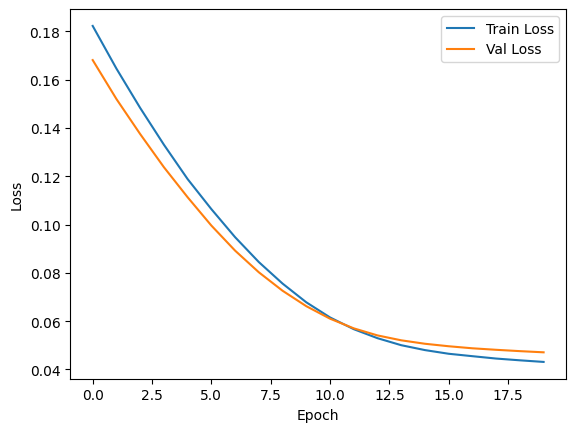

In [235]:
train_loss_sequential = history_sequential.history['loss']
val_loss_sequential = history_sequential.history['val_loss']
plt.plot(train_loss_sequential,label="Train Loss")
plt.plot(val_loss_sequential,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

for the sequential model we can see the scope between train los and val loss is close to each other indicating it could lead to a good model. we can see that Both losses decrease steadily over time, which means the model is learning and improving its predictions. Also the Training loss is consistently lower than the validation loss, which is normal. and like i said in the beginning that the Validation loss follows the training loss closely and does not diverge , it's a good sign that the model is not overfitting.

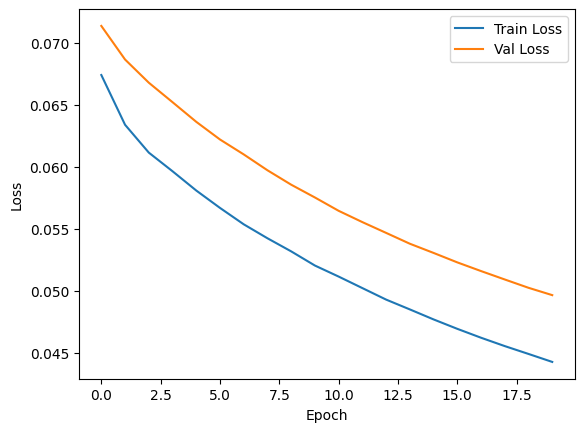

In [236]:
train_loss_functional = history_functional.history['loss']
val_loss_functional = history_functional.history['val_loss']
plt.plot(train_loss_functional,label="Train Loss")
plt.plot(val_loss_functional,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

for the functional model we can see that Both training loss and validation loss decrease consistently across epochs, which is good. However, the gap between train and val loss remains fairly wide and does not get smaller as training progresses.
Validation loss is not catching up, suggesting the model is starting to overfit a bit, especially if this trend continues. now lets get to the evaluation

### Evaluation Methods

so for the evaluation it wants minimum of 3 methods so for linear regression we're using MAE (Mean absoulte error), RMSE(root mean squared error),and r2 (r-squared)

In [304]:
def evaluate_model(model, test_ds, scaler_y):
    y_pred = model.predict(test_ds)
    y_pred_unscaled = scaler_y.inverse_transform(y_pred)
    y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1,1))
    metrics = {
        'MAE': mean_absolute_error(y_test_unscaled, y_pred_unscaled),
        'RMSE': np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled)),
        'R2': r2_score(y_test_unscaled, y_pred_unscaled),
    }
    return metrics

In [305]:
models = {
    'Sequential': model_sequential,
    'Functional': model_functional,
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, test_ds, scaler_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [306]:
pd.DataFrame(results).T.style.background_gradient(cmap='Blues')

,MAE,RMSE,R2
Sequential,7.046940,8.843387,0.104135
Functional,6.852894,8.481222,0.176010


So for the evaluation there's 3 methods:
1. Mean Absolute Error (MAE) for Measuring Average Prediction Accuracy

The Functional model give us (MAE = 6.852), this number performs better than the Sequential model (MAE = 7.46) because it makes smaller average errors. This means that, on average, the Functional model’s predictions are closer to the true values, suggesting it generalizes better. The difference may come from the skip connections and better regularization in the Functional model, which help maintain stable learning and reduce overfitting. judging that the negativity of relu making a vanishing gradient for the sequential. For the functional is a little bit better helped by the kernel and bias initializatons so makes it more stable. But still we can't say that this functional model is the best, but it's better than the sequential. We can also see in the training and vall that the score from the rmse loss and val.

2. Root Mean Squared Error (RMSE) to see which model do Large Prediction Mistakes

The Functional model (RMSE = 8.48) has a lower RMSE than the Sequential model (RMSE = 9.27), meaning it avoids extreme errors more effectively. RMSE heavily penalizes large mistakes, so this improvement suggests the Functional model’s helps control outlier predictions better than a simple Sequential model.

3. R-squared (R²) for Explaining Data Variance

The Functional model (R² = 0.176) explains more variance in the data than the Sequential model (R² = 0.10), though both scores are low. This means the Functional model captures slightly more patterns in the data, likely due to its multi-path structure (skip connections, multiple dense layers with different activations). However, the low R² for both models indicates that additional feature engineering or model tuning is still needed in this case.

overall we can see that The Functional model consistently outperforms the Sequential one across all three metrics, although the difference is modest.Also The performance gap aligns with the loss graphs: the Functional model generalizes slightly better, as seen from the smaller validation loss and evaluation metrics. However the bad news is that both our models may need hyper tuning to improve R² scores.

### Hyperparameter Tuning for Sequential Model

so here lets make a function for our hyperparameter tuning to lower our rmse and mae and increase the r^2.

In [240]:
def build_model(hp):
    model = tf.keras.Sequential()

    model.add(layers.Dense(units=hp.Int('input_units', min_value=32, max_value=256, step=32),
                          activation='relu',
                          input_shape=(28,)))

    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(layers.Dense(
            units=hp.Int(f'hidden_{i}_units', min_value=16, max_value=128, step=16),
            activation=hp.Choice(f'hidden_{i}_activation', ['relu', 'elu', 'tanh'])
        ))
        if hp.Boolean(f'dropout_{i}'):
            model.add(layers.Dropout(
                rate=hp.Float(f'dropout_{i}_rate', min_value=0.1, max_value=0.5, step=0.1)
            ))

    model.add(layers.Dense(1, activation='linear'))

    learning_rate = hp.Float('lr', min_value=1e-5, max_value=1e-3, sampling='log')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

There's some reasoning and point i want to highlight in my tuning:

1. When I built the Sequential model, I wanted to give it enough flexibility to learn well without making it overly complex. So for the first layer, I let the tuner pick how many neurons to use from a small size like 32 up to 256. This is because sometimes a small network is enough, but if the problem is harder, more neurons might help it learn better.

2. Then, I let the model have between 1 to 3 hidden layers, each with its own number of neurons (between 16 and 128) and activation function like ReLU, ELU, or Tanh. I did this to let the model choose how deep and non-linear it needs to be to capture the patterns in the data.

3. To help prevent overfitting, I gave the option to add dropout layers after each hidden layer, where the dropout rate can range from 0.1 to 0.5. Dropout randomly turns off some neurons during training so the model doesn’t rely too heavily on any single feature. Lastly, I tuned the learning rate because it’s a really important part of how fast and smoothly the model learns.

4. I used a range from 1e-5 to 1e-3 to make sure the optimizer (Adam) had enough options to find what works best—too high could make it unstable, too low could make training very slow. Overall, my goal with this tuning setup was to keep things balanced: let the model be as simple or as complex as needed, while still learning efficiently and generalizing well.

In [241]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=30,
    factor=3,
    directory='tuning_dir',
    project_name='sequential_tuning'
)

Reloading Tuner from tuning_dir/sequential_tuning/tuner0.json


oh yeah we use early_stopping, so when model doesnt improve in a lot of epochs it will stop or the increase or decrease it's not significant. This makes our model train and develop faster.

In [242]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [243]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

In [244]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal hyperparameters:
- Input layer units: {best_hps.get('input_units')}
- Number of hidden layers: {best_hps.get('n_layers')}
- Learning rate: {best_hps.get('lr')}
""")

best_model = tuner.hypermodel.build(best_hps)


Optimal hyperparameters:
- Input layer units: 160
- Number of hidden layers: 3
- Learning rate: 0.0008961015644502074



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


and here's the optimal result for our sequential model lets input and try it with best model as our model

In [245]:
history_optimized_sequential = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.2291 - mae: 0.3832 - root_mean_squared_error: 0.4708 - val_loss: 0.0697 - val_mae: 0.2193 - val_root_mean_squared_error: 0.2639
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0864 - mae: 0.2404 - root_mean_squared_error: 0.2938 - val_loss: 0.0407 - val_mae: 0.1600 - val_root_mean_squared_error: 0.2016
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0676 - mae: 0.2059 - root_mean_squared_error: 0.2600 - val_loss: 0.0409 - val_mae: 0.1611 - val_root_mean_squared_error: 0.2021
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0510 - mae: 0.1808 - root_mean_squared_error: 0.2258 - val_loss: 0.0437 - val_mae: 0.1687 - val_root_mean_squared_error: 0.2089
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0483 - mae: 0.1743 - root_mean_squared_error: 0.2197 - val_loss: 0.0411 - val_mae: 0.1621 - val_root_mean_squared_error: 0.2027
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

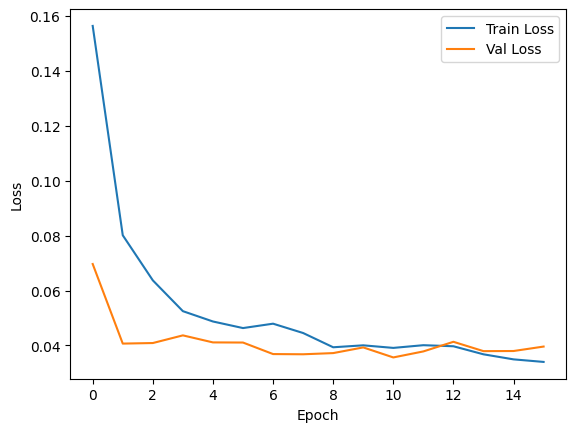

In [246]:
train_loss_optimized = history_optimized_sequential.history['loss']
val_loss_optimized = history_optimized_sequential.history['val_loss']
plt.plot(train_loss_optimized,label="Train Loss")
plt.plot(val_loss_optimized,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Sequential model VS Tuned Sequential Model

for the tuned Sequential model, we can see that the training loss decreases quickly, and the validation loss improves a lot during the first few epochs. However, around epoch 6, the validation loss starts to level off and even increase a little. This is where overfitting could begin. But since I used EarlyStopping with patience set to 5, the model didn't continue training indefinitely. Instead, it paused to see if the validation loss would improve, and then stopped when it reached the best point, restoring the model weights from the epoch with the lowest validation loss.

Compared to the earlier version of the Sequential model (which trained for all 20 epochs), this one is more efficient. It learns faster, stops at the right time, and with restore_best_weights=True, it keeps the most generalizable version of the model. So, in the end, the tuning I applied helps the model learn better, and EarlyStopping ensures it doesn’t go too far and overfit.

In [247]:
import keras_tuner as kt
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_model(hp):
    inputs = Input(shape=(x_train.shape[1],))

    hp_units1 = hp.Int('units1', min_value=32, max_value=256, step=32)
    dense1 = Dense(
        units=hp_units1,
        activation=hp.Choice('activation1', ['relu', 'leaky_relu', 'swish']),
        kernel_initializer=hp.Choice('init1', ['glorot_uniform', 'he_normal'])
    )(inputs)

    hp_units2 = hp.Int('units2', min_value=16, max_value=128, step=16)
    dense2 = Dense(
        units=hp_units2,
        activation=hp.Choice('activation2', ['relu', 'leaky_relu', 'swish']),
        kernel_initializer=hp.Choice('init2', ['glorot_uniform', 'he_normal'])
    )(dense1)

    hp_units3 = hp.Int('units3', min_value=8, max_value=64, step=8)
    dense3 = Dense(
        units=hp_units3,
        activation=hp.Choice('activation3', ['relu', 'leaky_relu', 'swish'])
    )(dense2)

    cat_layer = Concatenate(axis=1)([dense3, dense2])

    out = Dense(1, activation='linear')(cat_layer)

    model = Model(inputs=inputs, outputs=out)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 5e-5])

    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='mse',
        metrics=['mae', 'mse']
    )

    return model

for the Hyperparameter tuning. lets start with The hp, which is used to define a search space for different hyperparameters. This is where the model becomes smarter because it will experiment with different values for certain parameters and find the ones that work best. Here are the parts I tuned:

1. Number of Units (units1, units2, units3): For each dense layer, I define a range of units that the model can choose from. This helps find the optimal number of neurons in each layer.

2. Activation Function (activation1, activation2, activation3): The activation function plays a crucial role in how the model learns. I let the model choose between relu, leaky_relu, and swish for each layer, since these are popular choices that can help the model converge better.

3. Kernel Initializer (init1, init2): This controls how the weights of the neurons are initialized. I allowed two common initializers: glorot_uniform and he_normal, since they are often effective in deep learning.

5. Learning Rate (learning_rate): I tuned the learning rate of the optimizer (Adam). The learning rate controls how much the weights are adjusted during training. I chose four different values: 1e-2, 1e-3, 1e-4, and 5e-5. This gives the model flexibility in finding the optimal learning rate.

In [248]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='tuning_dir',
    project_name='functional_model_tuning'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

tuner.search(
    train_ds,
    epochs=100,
    validation_data=(val_ds),
    callbacks=[stop_early]
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal hyperparameters:
- Layer 1 units: {best_hps.get('units1')}
- Layer 1 activation: {best_hps.get('activation1')}
- Layer 1 initializer: {best_hps.get('init1')}
- Layer 2 units: {best_hps.get('units2')}
- Layer 2 activation: {best_hps.get('activation2')}
- Layer 2 initializer: {best_hps.get('init2')}
- Layer 3 units: {best_hps.get('units3')}
- Layer 3 activation: {best_hps.get('activation3')}
- Learning rate: {best_hps.get('learning_rate')}
""")

final_model = tuner.hypermodel.build(best_hps)

history_final = final_model.fit(
    train_ds,
    validation_data=(val_ds),
    epochs=200,
    callbacks=[stop_early]
)

Reloading Tuner from tuning_dir/functional_model_tuning/tuner0.json

Optimal hyperparameters:
- Layer 1 units: 32
- Layer 1 activation: leaky_relu
- Layer 1 initializer: glorot_uniform
- Layer 2 units: 16
- Layer 2 activation: leaky_relu
- Layer 2 initializer: glorot_uniform
- Layer 3 units: 24
- Layer 3 activation: relu
- Learning rate: 0.01

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1034 - mae: 0.2529 - mse: 0.1034 - val_loss: 0.0389 - val_mae: 0.1571 - val_mse: 0.0389
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0355 - mae: 0.1510 - mse: 0.0355 - val_loss: 0.0377 - val_mae: 0.1537 - val_mse: 0.0377
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - mae: 0.1378 - mse: 0.0296 - val_loss: 0.0402 - val_mae: 0.1625 - val_mse: 0.0402
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 - mae: 0.1330 - mse: 0.0273 - val_loss: 0.0399 - val_mae: 0.1614 - val_mse: 0.0399
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

and we're set lets take a look at the final result

In [250]:
models = {
    'Optimized Sequential': best_model,
    'Modified Functional': final_model
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model,test_ds, scaler_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


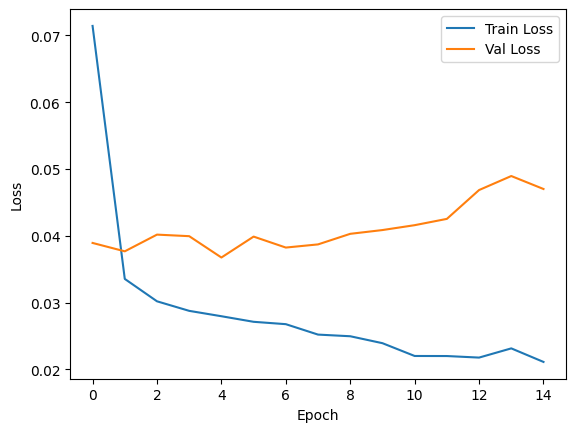

In [251]:
train_loss_final = history_final.history['loss']
val_loss_final = history_final.history['val_loss']
plt.plot(train_loss_final,label="Train Loss")
plt.plot(val_loss_final,label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [252]:
models = {
    'Optimized Sequential': best_model,
    'Modified Functional': final_model,
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, test_ds, scaler_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [253]:
pd.DataFrame(results).T.style.background_gradient(cmap='Blues')

,MAE,RMSE,R2
Optimized Sequential,6.091936,7.753808,0.311292
Modified Functional,6.765034,8.474812,0.177255


In [307]:
models = {
    'Sequential': model_sequential,
    'Functional': model_functional,
    'Optimized Sequential': best_model,
    'Optimized Functional': final_model,
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, test_ds, scaler_y)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [308]:
pd.DataFrame(results).T.style.background_gradient(cmap='Blues')

,MAE,RMSE,R2
Sequential,7.046940,8.843387,0.104135
Functional,6.852894,8.481222,0.176010
Optimized Sequential,6.091936,7.753808,0.311292
Optimized Functional,6.765034,8.474812,0.177255


1. Mean Absolute Error (MAE)

MAE tells us how far off our predictions are from the actual energy usage, on average. It’s in the same unit as the target (likely kilowatts or similar). Lower is better.

- The Optimized Sequential model has the lowest MAE at 6.09, which means it’s making predictions that are, on average, only around 6 units away from the actual energy use.
- The Functional models perform slightly worse, with the basic Functional model at 6.85 and even the Optimized Functional model at 6.76.
- The basic Sequential model sits in between at 7.04.
So, in terms of average accuracy, Optimized Sequential is the best.

so we can say that the best model to predict the actual energy usage is Optimized sequential model, we can also see from the graph that is not that different between val loss and train loss indicating it's a good model and not overfit.

2. for RMSE is kinda similar to MAE, but it penalizes larger errors more heavily. Again, lower is better.

- The Optimized Sequential model again performs best with an RMSE of 7.75, meaning its predictions have the smallest overall deviation.
- The Optimized Functional and basic Functional models are tied closely at around 8.47–8.48, while the basic Sequential model is slightly worse at 8.84.

This reinforces that the Optimized Sequential model is the most consistent and stable in its predictions.

3. R^2 tells us how well the model explains the variability in energy usage. The closer to 1, the better.

- Here, Optimized Sequential stands out again with the highest R^2 of 0.31, meaning it explains about 31% of the variation in energy use.
- The Functional models both hover around 0.17, and the basic Sequential model trails behind at just 0.10.

This means the Optimized Sequential model captures the most meaningful patterns in the data.

although i can't say that 31% is the best result for this case but it's what it's. we got 31% for the best model out of the 4 that we have.

# CONCLUSION

From all three evaluation metrics MAE, RMSE, and R^2 we can clearly see that the Optimized Sequential model outperforms the rest. It not only gives the most accurate and stable predictions, but also explains the largest portion of the variation in energy consumption. This suggests that our hyperparameter tuning significantly improved the model’s learning capability, helping it better understand the energy usage patterns in buildings with solar panels.

So, if we had to pick one model to use for real-world prediction, the Optimized Sequential model is our best choice.